# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [1]:
import os
from getpass import getpass
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!nvidia-smi

Fri May  6 16:45:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/GarrickZ2/Image-Denoising

Cloning into 'Image-Denoising'...
remote: Enumerating objects: 907, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 907 (delta 173), reused 160 (delta 79), pack-reused 626
Receiving objects: 100% (907/907), 25.58 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (472/472), done.


In [4]:
%cd Image-Denoising
%ls

/content/Image-Denoising
Coordinator/        Makefile  README.md   RIDNet/
load_dataset.ipynb  PNGAN/    Restormer/


In [7]:
import sys
sys.path.append('/content/Image-Denoising/PNGAN')

In [18]:
# from PNGAN.util import utility
# from PNGAN.util.option import args
# from PNGAN.model import ridnet
from PNGAN.model.generator import Generator
# from PNGAN.model.discriminator import *
# from PNGAN.loss.loss import *
from PNGAN.util.utility import visualize, denormalize
# args.pre_train = './PNGAN/experiment/ridnet.pt'

# Download visualization data

In [13]:
!wget https://storage.googleapis.com/yy3185/SIDD_val_patches.zip
!unzip -q SIDD_val_patches.zip

--2022-05-06 16:47:20--  https://storage.googleapis.com/yy3185/SIDD_val_patches.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303792755 (290M) [application/zip]
Saving to: ‘SIDD_val_patches.zip’

SIDD_val_patches.zi 100%[===================>] 289.72M  30.4MB/s    in 9.5s    

2022-05-06 16:47:31 (30.4 MB/s) - ‘SIDD_val_patches.zip’ saved [303792755/303792755]



In [22]:
from PNGAN.dataset.dataset import SIDDSmallDataset, AdditiveGaussianWhiteNoise
from torch.utils.data import DataLoader

val_ds = SIDDSmallDataset('./Datasets', data_type='val', noise_generator=AdditiveGaussianWhiteNoise())
val_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
len(val_ds), len(val_loader)

(5120, 1280)

# Download and Load Model Checkpoint

In [15]:
!wget https://storage.googleapis.com/yy3185/pngan_sidd.pt -O /content/pngan_sidd.pt

--2022-05-06 16:47:59--  https://storage.googleapis.com/yy3185/pngan_sidd.pt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25284633 (24M) [application/octet-stream]
Saving to: ‘/content/pngan_sidd.pt’

/content/pngan_sidd 100%[===================>]  24.11M  53.8MB/s    in 0.4s    

2022-05-06 16:48:00 (53.8 MB/s) - ‘/content/pngan_sidd.pt’ saved [25284633/25284633]



In [16]:
def load_generator_checkpoint(netG, ckpt_file):
  ckpt = torch.load(ckpt_file)
  netG.load_state_dict(ckpt['modelG'])

netG = Generator(3, 64).to(device)
load_generator_checkpoint(netG, '/content/pngan_sidd.pt')
netG.eval()
for param in netG.parameters():
  param.require_grad = False

# Visualize PNGAN Output

In [17]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


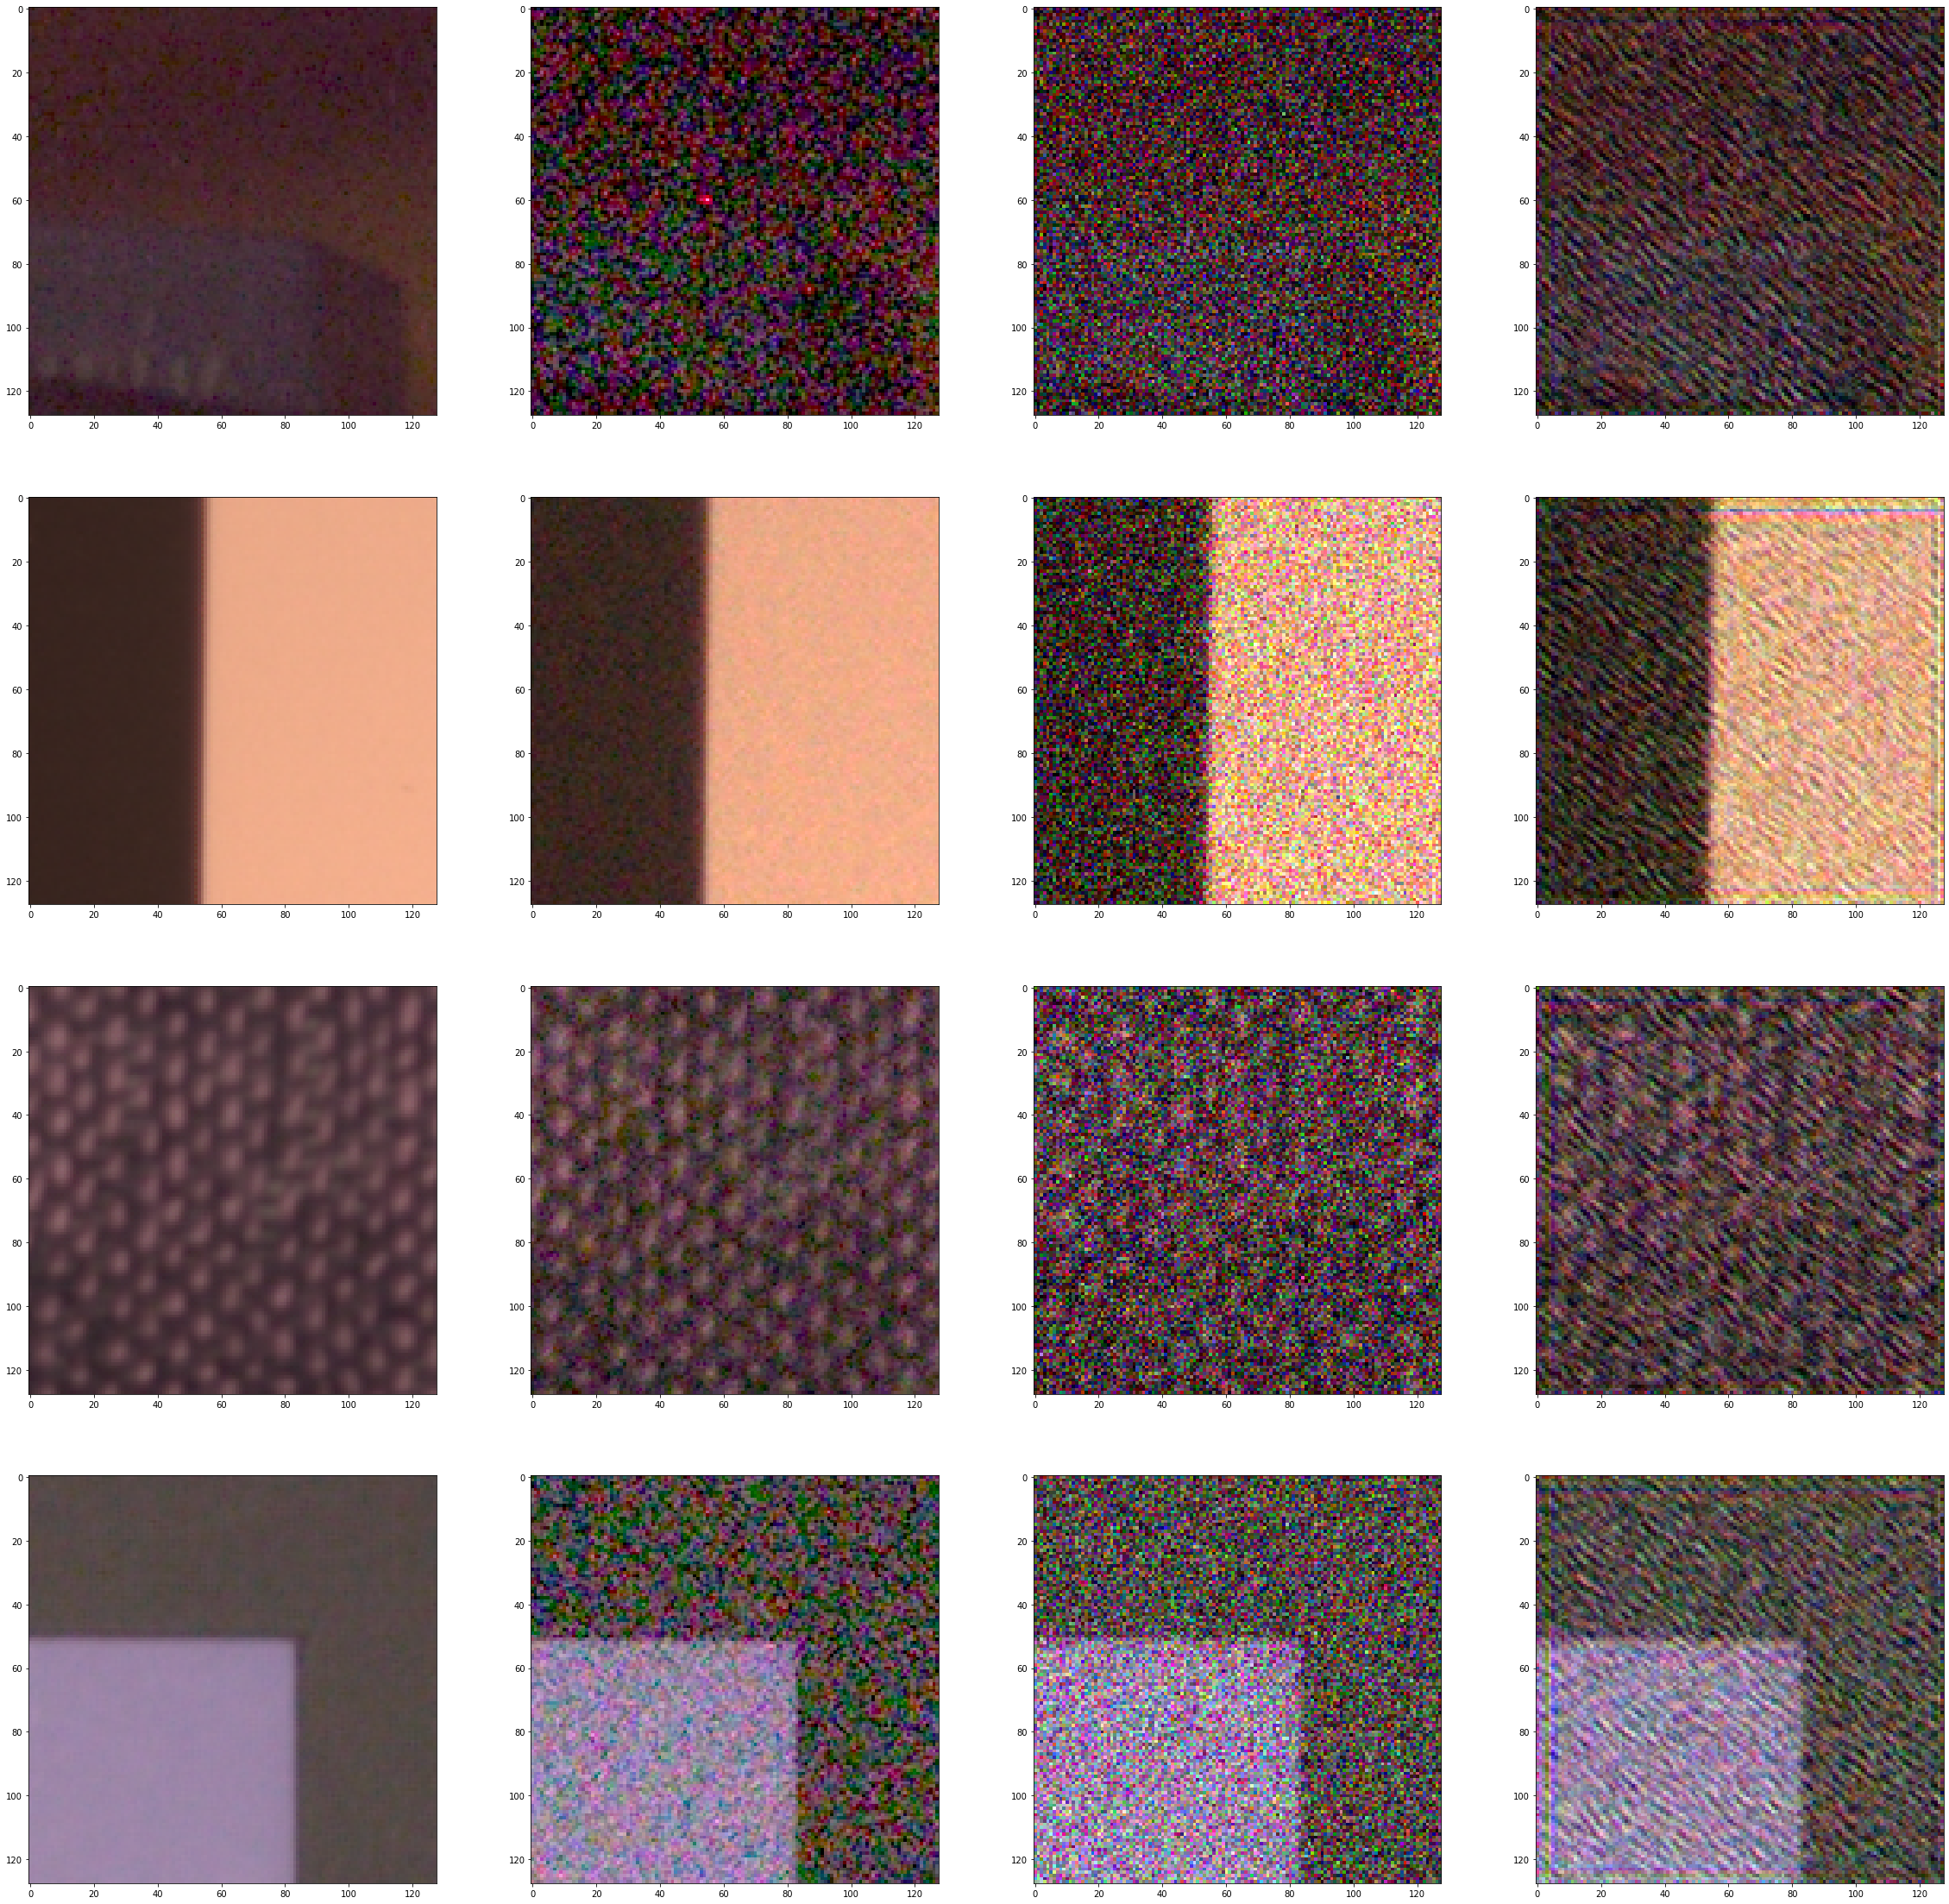

In [23]:
clean, real, fake = next(iter(val_loader))
aligned = netG(fake.to(device)).detach().cpu()
visualize(clean, real, fake, aligned)

--2022-05-06 16:50:42--  https://storage.googleapis.com/maskgit-public/imgs/class_cond_input_1.png
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.251.8.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396555 (387K) [image/png]
Saving to: ‘class_cond_input_1.png’

class_cond_input_1. 100%[===================>] 387.26K  --.-KB/s    in 0.003s  

2022-05-06 16:50:42 (116 MB/s) - ‘class_cond_input_1.png’ saved [396555/396555]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


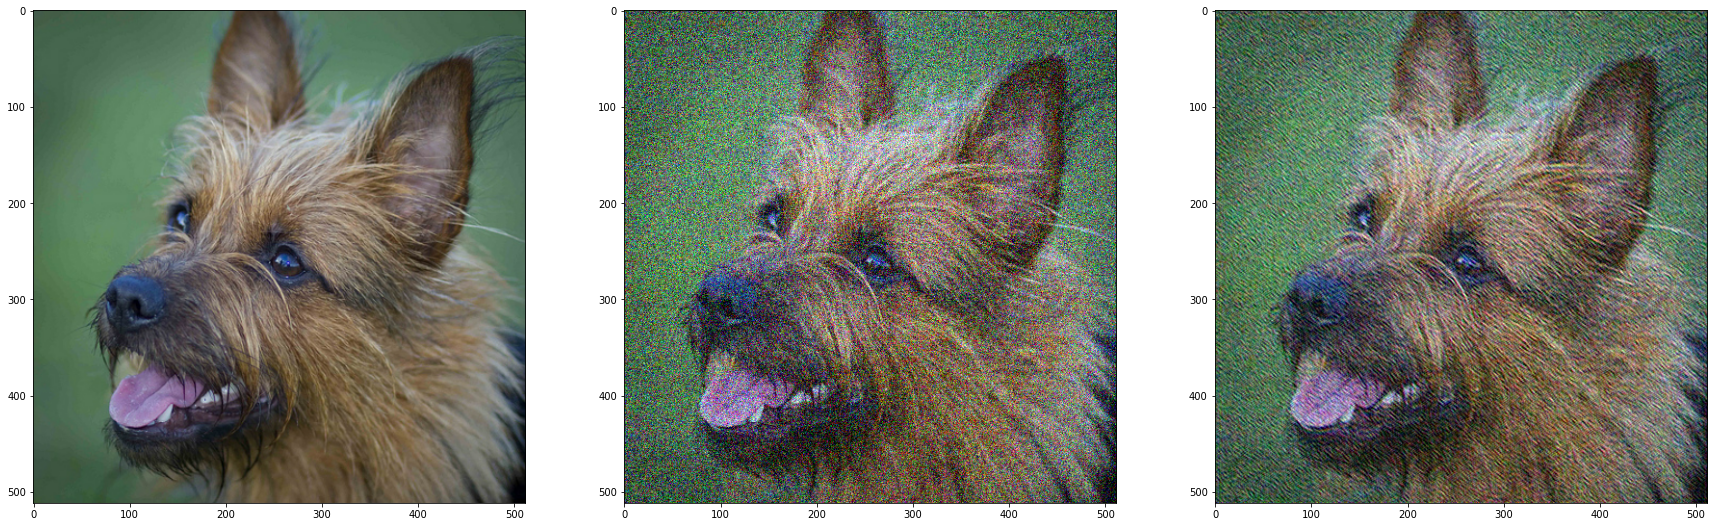

In [21]:
img_url = 'https://storage.googleapis.com/maskgit-public/imgs/class_cond_input_1.png' # @param
filename = img_url.split('/')[-1]

!wget {img_url} -O {filename}

# preprocessing
import cv2
from PIL import Image
import torchvision.transforms as transforms

to_noisy = transforms.Compose([
  transforms.ToTensor(),
  AdditiveGaussianWhiteNoise(std=50.),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# run model
# img = cv2.imread(filename)
img = Image.open(filename)
in_img = to_noisy(img)[None].to(device)
out_img = netG(in_img)

# display output
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[1].imshow(denormalize(in_img)[0].detach().cpu().permute(1,2,0))
axes[2].imshow(denormalize(out_img)[0].detach().cpu().permute(1,2,0))